In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np

#using architecture as an example, lets find some key topics
reviews_df = pd.read_csv('Data/filtered_reviews/bible_df.csv', usecols=['title', 'review_summary', 'review_score'])
reviews_df.head(10)

,title,review_score,review_summary
0,Principles of Biblical Interpretation (Sacred ...,0.75,A Standard Work From Which To Start
1,Principles of Biblical Interpretation (Sacred ...,0.75,Good summary of most important features
2,Principles of Biblical Interpretation (Sacred ...,1.00,Great Books
3,the modern use of the bible,0.75,An excellent aid
4,"Come sweet death: A quintet from Genesis: 12345,",1.00,Preaching as Storytelling-Par Excellence
5,"Come sweet death: A quintet from Genesis: 12345,",0.75,"A complex, lyrical retelling of the Genesis st..."
6,"Word Biblical Commentary Vol. 2, Genesis 16-50...",1.00,Very good treatment from a literary perspective
7,"Word Biblical Commentary Vol. 2, Genesis 16-50...",1.00,Between Wenham and Hamilton
8,"Word Biblical Commentary Vol. 2, Genesis 16-50...",0.75,Critical Commentary
9,The Letter Writer,1.00,A compelling satirical spoof of those frantic ...


In [2]:
# we need topics for each review which summarise them. We have the function below which takes the model which we will define later, 
# the kinds of words or terms that correspond to topics and a count of representative words or topics we want. It then iterates through the 
# model giving an index to each topic and assigning each item in the model a topic and finally printing these results.

def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        #using featurenames to list topics whilst trying to remove simple words that aren't as informative
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1] if feature_names[i] not in ('book', 'books', 'great', 'nice',
                                                                                                                   'read', 'good')]
        topics[f'Topic {topic_idx + 1}'] = ' '.join(topic_words)
    return topics

In [3]:
# our main function for performing topic modelling

def main_topics(reviews_df):
    # CountVectorizer converts the text into a term-document matrix. Rows correspond to documents and columns to words and looks at frequency of words.
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    reviews_df['review_summary'] = reviews_df['review_summary'].fillna('')
    doc_term_matrix = vectorizer.fit_transform(reviews_df['review_summary'])
    
    # LDA is the topic modelling function which finds topics in documents - we have specified 5 topics per document
    lda = LatentDirichletAllocation(n_components=5, random_state=0)
    lda.fit(doc_term_matrix)

    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Create topic-word DataFrame
    topic_word_matrix = lda.components_
    topics_df = pd.DataFrame(topic_word_matrix, columns=feature_names)

    # we then use the previous function to display the top 10 words given to each of the 5 topics
    no_top_words = 10
    topics = display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)
    return topics_df, doc_term_matrix, vectorizer, topics  

In [4]:
topics_df, doc_term_matrix, vectorizer, topics = main_topics(reviews_df)

print('Featured topics in the test: ', topics)

Featured topics in the test:  {'Topic 1': 'reference new best translation excellent testament christian old', 'Topic 2': 'god biblical easy study quot dated history free', 'Topic 3': 'life jesus times messiah wonderful kindle insight excellent edersheim version', 'Topic 4': 'hard bible jewish work topical nave commentary', 'Topic 5': 'bible excellent study resource reading interesting'}


# Summary: 
we have generated some topics from these books but as we can see there is nothing really connecting them and they 
all seem to be similar to 'good' or 'great'. To get better results we will attempt to use a genre filter in the hopes there
# are more obvious common topics within genres

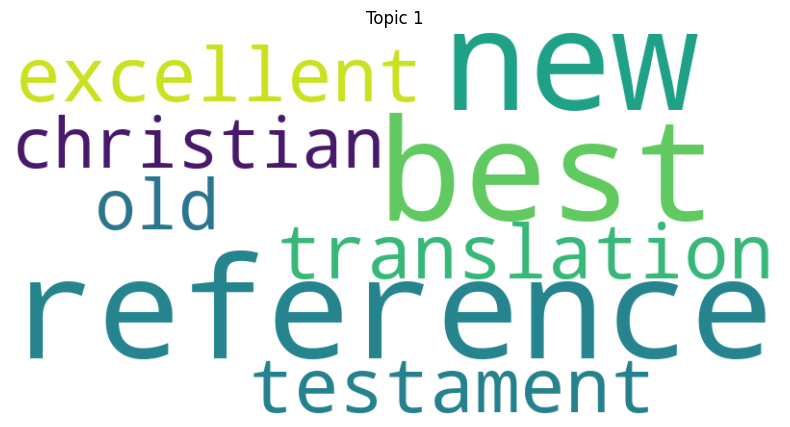

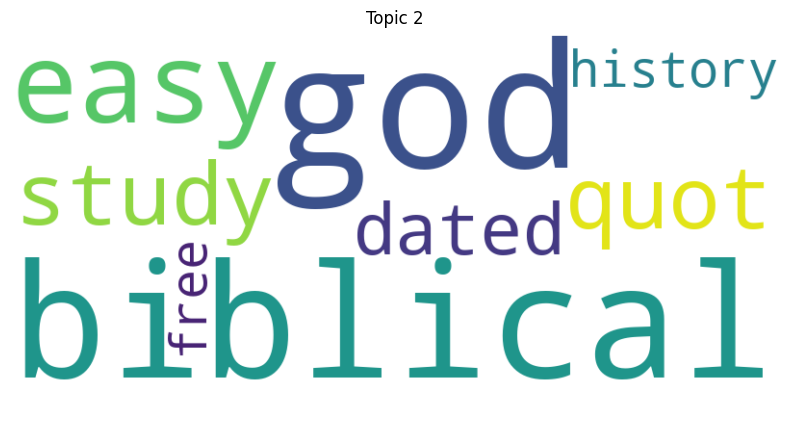

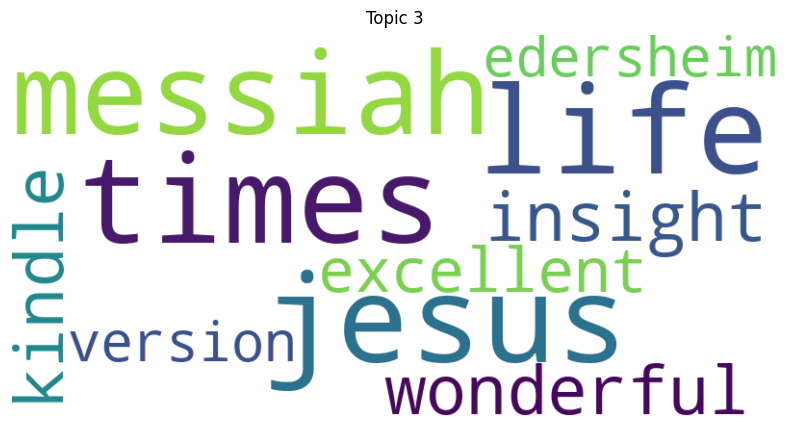

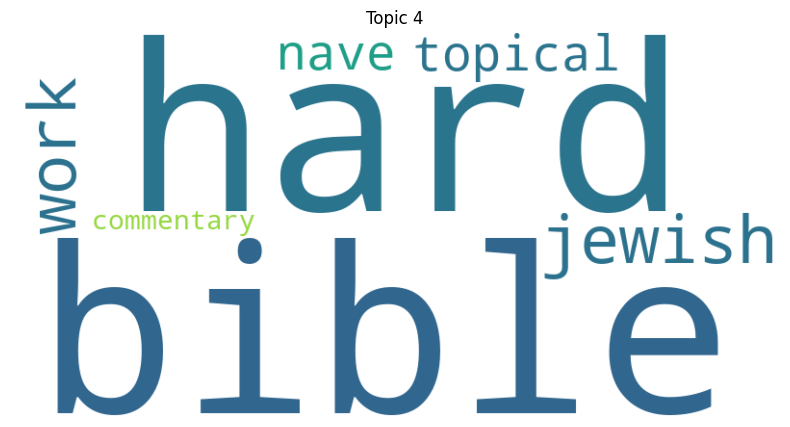

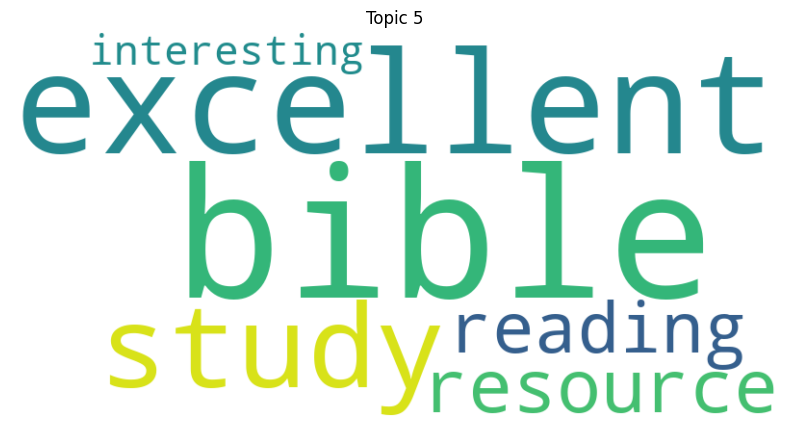

In [5]:
for topic, words in topics.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(topic)
    plt.axis('off')
    plt.show()

In [6]:
def plot_keyword_density(doc_term_matrix, feature_names):
    # Adding up all of the occurrences of each keyword
    keyword_counts = np.asarray(doc_term_matrix.sum(axis=0)).flatten()
    
    # To assist with plotting, create a DataFrame
    keyword_freq_df = pd.DataFrame({'keyword': feature_names, 'count': keyword_counts})
    keyword_freq_df = keyword_freq_df.sort_values(by='count', ascending=False)
    
    # Plot density map using seaborn
    plt.figure(figsize=(12, 6))
    sns.barplot(x='keyword', y='count', data=keyword_freq_df.head(20))  # Top 20 keywords
    plt.xticks(rotation=45)
    plt.title('Keyword Density')
    plt.xlabel('Keyword')
    plt.ylabel('Frequency')
    plt.show()

In [7]:
# now we want a function that will help us plot the density of each keyword, we will take the dataframe, keywords and a doc-term matrix as input

def plot_keyword_rating_density(reviews_df, doc_term_matrix, feature_names):
    # Convert the doc-term matrix to a DataFrame
    keywords_df = pd.DataFrame(doc_term_matrix.toarray(), columns=feature_names)
    
    # Combining the keyword counts with the original ratings in the reviews_df dataframe
    combined_df = pd.concat([reviews_df[['review_score']], keywords_df], axis=1)
    
    # Calculate the density of keywords per rating by using groupby
    rating_keyword_density = combined_df.groupby('review_score').sum()
    
    # Find the average by dividing each keyword count by the total number of reviews for that rating
    rating_counts = reviews_df['review_score'].value_counts().sort_index()
    rating_keyword_density = rating_keyword_density.div(rating_counts, axis=0)
    
    # Select the top N keywords by overall frequency (too many keywords to count all)
    keyword_totals = keywords_df.sum().sort_values(ascending=False)
    top_keywords = keyword_totals.head(10).index
    rating_keyword_density = rating_keyword_density[top_keywords]
    
    # Plot heatmap of keyword-rating density
    plt.figure(figsize=(12, 8))
    sns.heatmap(rating_keyword_density, annot=True, cmap='viridis', center=0)
    plt.title('Density/Probability of Keywords by Book Ratings')
    plt.xlabel('Keywords')
    plt.ylabel('Ratings')
    plt.show()

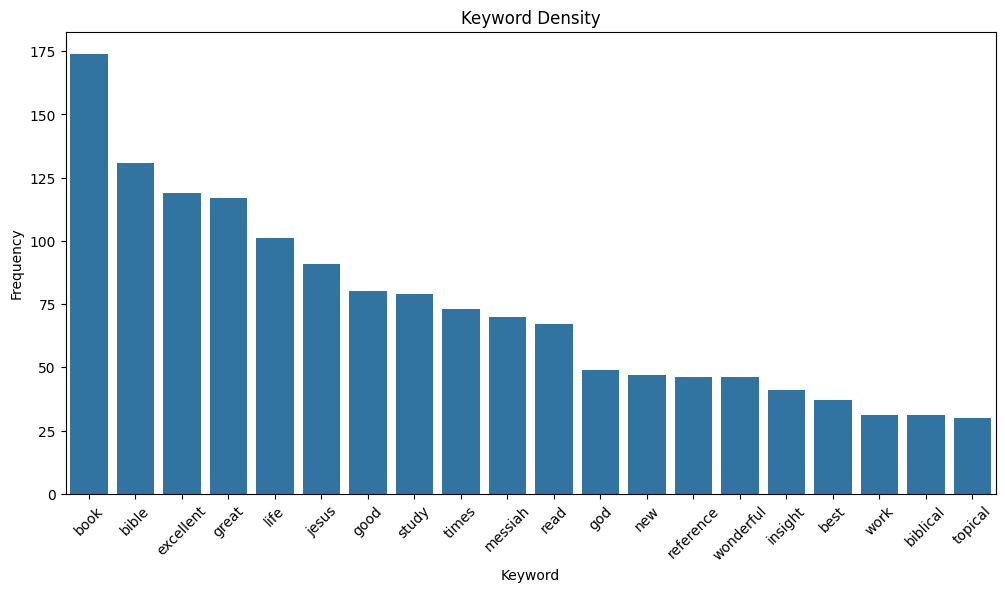

In [8]:
# Plot keyword density map
plot_keyword_density(doc_term_matrix, vectorizer.get_feature_names_out())

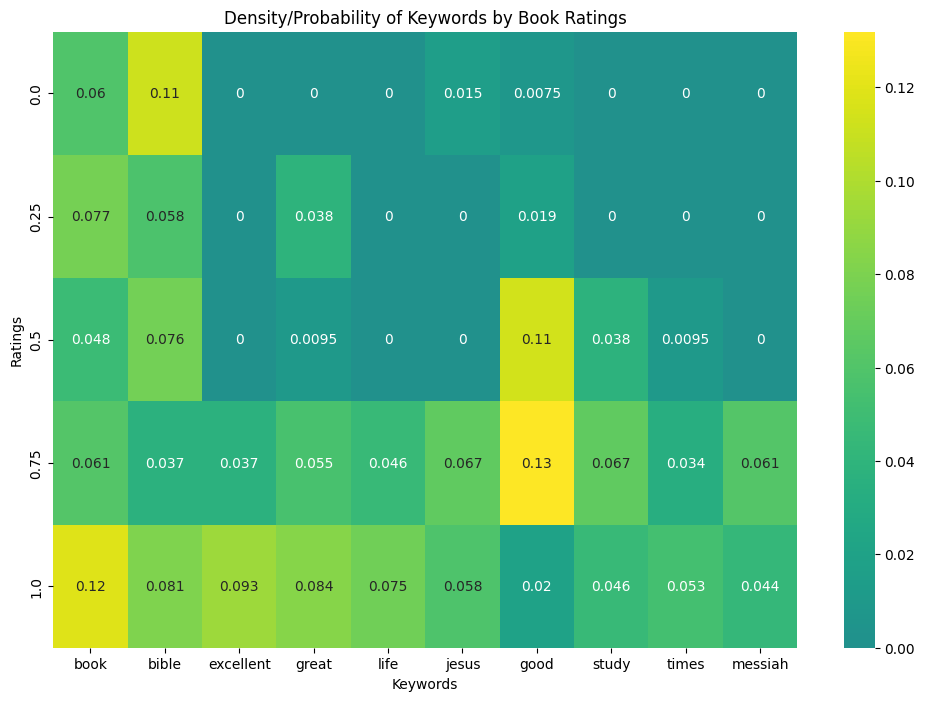

In [9]:
# Plot keyword-rating map
plot_keyword_rating_density(reviews_df, doc_term_matrix, vectorizer.get_feature_names_out())